In [1]:
import os, sys # add MaaSSim to path (not needed if MaaSSim is already in path)
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import MaaSSim

In [6]:
%load_ext autoreload
%autoreload 2

In [2]:
import MaaSSim.utils
import logging
from dotmap import DotMap
import MaaSSim.simulators
from MaaSSim.data_structures import structures as inData
from MaaSSim.acceptance import f_decline

In [3]:
# https://github.com/uber/h3-py-notebooks/tree/master/notebooks
import h3
import folium
import pandas as pd
import matplotlib.pyplot as plt
import osmnx as ox
import networkx as nx
import random
import pandas as pd
import numpy as np
import seaborn as sns

In [8]:
lat, lng = 37.769377, -122.388903
resolution = 8
h3_address = h3.geo_to_h3(lat, lng, resolution)
h3_address

'88283082e7fffff'

In [9]:
h3_address = h3.geo_to_h3(37.3615593, -122.0553238, 9) # lat, lng, hex resolution                                                                                                        
hex_center_coordinates = h3.h3_to_geo(h3_address)
hex_center_coordinates

(37.36267258237806, -122.05443585718207)

In [10]:
def visualize_hexagons(hexagons, color="red", w=1, folium_map=None):
    """
    hexagons is a list of hexcluster. Each hexcluster is a list of hexagons. 
    eg. [[hex1, hex2], [hex3, hex4]]
    """
    polylines = []
    lat = []
    lng = []
    for hex in hexagons:
        polygons = h3.h3_set_to_multi_polygon([hex], geo_json=False)
        # flatten polygons into loops.
        outlines = [loop for polygon in polygons for loop in polygon]
        polyline = [outline + [outline[0]] for outline in outlines][0]
        lat.extend(map(lambda v:v[0],polyline))
        lng.extend(map(lambda v:v[1],polyline))
        polylines.append(polyline)
    
    if folium_map is None:
        m = folium.Map(location=[sum(lat)/len(lat), sum(lng)/len(lng)], zoom_start=13, tiles='cartodbpositron')
    else:
        m = folium_map
    for polyline in polylines:
        my_PolyLine=folium.PolyLine(locations=polyline,weight=w,color=color,fill= True)
        m.add_child(my_PolyLine)
    return m
    

def visualize_polygon(polyline, color):
    polyline.append(polyline[0])
    lat = [p[0] for p in polyline]
    lng = [p[1] for p in polyline]
    m = folium.Map(location=[sum(lat)/len(lat), sum(lng)/len(lng)], zoom_start=13, tiles='cartodbpositron')
    my_PolyLine=folium.PolyLine(locations=polyline,weight=8,color=color)
    m.add_child(my_PolyLine)
    return m

In [11]:
h3_address = h3.geo_to_h3(37.3615593, -122.0553238, 8) # lat, lng, hex resolution                                                                                                        
m = visualize_hexagons([h3_address])
display(m)

In [43]:
h3_address = h3.geo_to_h3(37.3615593, -122.0553238, 9) # lat, lng, hex resolution                                                                                                        
hex_center_coordinates = h3.h3_to_geo(h3_address) # array of [lat, lng]                                                                                                                  
hex_boundary = h3.h3_to_geo_boundary(h3_address) # array of arrays of [lat, lng]
m = visualize_hexagons(list(h3.k_ring_distances(h3_address, 4)[3]), color="purple")
m = visualize_hexagons(list(h3.k_ring_distances(h3_address, 4)[2]), color="blue", folium_map=m)
m = visualize_hexagons(list(h3.k_ring_distances(h3_address, 4)[1]), color="green", folium_map=m)
m = visualize_hexagons(list(h3.k_ring_distances(h3_address, 4)[0]), color = "red", folium_map=m)


list(h3.k_ring(h3_address,1))

display(m)

In [44]:
noise_311_link = 'https://gist.githubusercontent.com/kashuk/670a350ea1f9fc543c3f6916ab392f62/raw/4c5ced45cc94d5b00e3699dd211ad7125ee6c4d3/NYC311_noise.csv'
df311 = pd.read_csv(noise_311_link)
df311

lat        lng
0      40.744989 -73.924964
1      40.590929 -74.072404
2      40.728413 -73.994252
3      40.603440 -74.011571
4      40.737613 -74.002905
...          ...        ...
99995  40.709723 -73.828881
99996  40.821107 -73.935743
99997  40.623986 -74.033779
99998  40.634456 -74.027728
99999  40.771206 -73.924613

[100000 rows x 2 columns]

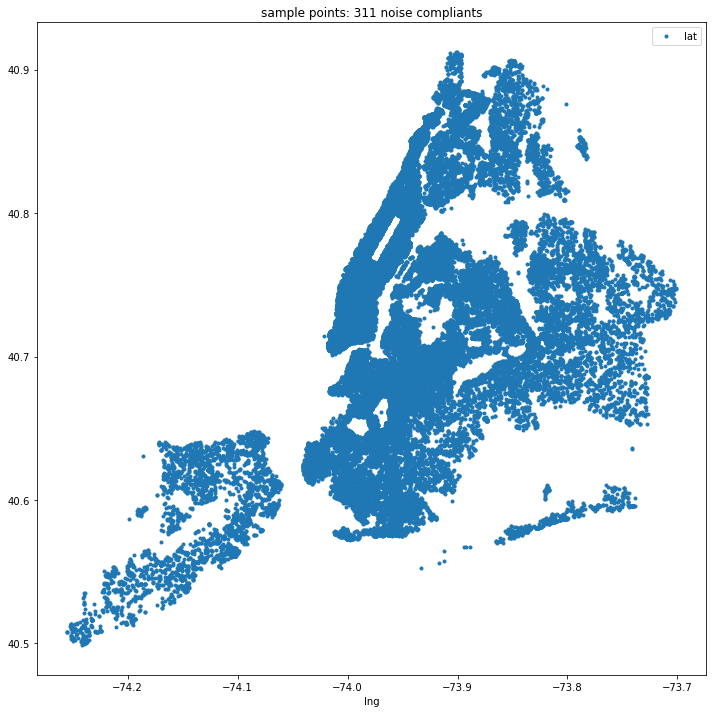

In [45]:
# Visualize the 311 noise complaints points
df311.plot(x='lng',y='lat',style='.',alpha=1,figsize=(12,12));
plt.title('sample points: 311 noise compliants');

In [46]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import shapely
import rtree
import geopandas
import xarray as xr
from geopandas import GeoDataFrame
from shapely.geometry import mapping
from shapely.ops import cascaded_union#, unary_union
import h3
import base64
import urllib
import tempfile
# import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

#Functions
def plot_scatter(df, metric_col, x='lng', y='lat', marker='.', alpha=1, figsize=(16,12), colormap='viridis'):    
    df.plot.scatter(x=x, y=y, c=metric_col, title=metric_col
                    , edgecolors='none', colormap=colormap, marker=marker, alpha=alpha, figsize=figsize);
    plt.xticks([], []); plt.yticks([], [])

def aperture_downsampling(df, hex_col, metric_col, coarse_aperture_size):
    df_coarse = df.copy()
    coarse_hex_col = 'hex{}'.format(coarse_aperture_size)
    df_coarse[coarse_hex_col] = df_coarse[hex_col].apply(lambda x: h3.h3_to_parent(x,coarse_aperture_size))
    dfc = df_coarse.groupby([coarse_hex_col])[[metric_col,]].mean().reset_index()
    dfc['lat'] = dfc[coarse_hex_col].apply(lambda x: h3.h3_to_geo(x)[0])
    dfc['lng'] = dfc[coarse_hex_col].apply(lambda x: h3.h3_to_geo(x)[1]) 
    return dfc

def kring_smoothing(df, hex_col, metric_col, k):
    dfk = df[[hex_col]] 
    dfk.index = dfk[hex_col]
    dfs =  (dfk[hex_col]
                 .apply(lambda x: pd.Series(list(h3.k_ring(x,k)))).stack()
                 .to_frame('hexk').reset_index(1, drop=True).reset_index()
                 .merge(df[[hex_col,metric_col]]).fillna(0)
                 .groupby(['hexk'])[[metric_col]].sum().divide((1 + 3 * k * (k + 1)))
                 .reset_index()
                 .rename(index=str, columns={"hexk": hex_col}))
    dfs['lat'] = dfs[hex_col].apply(lambda x: h3.h3_to_geo(x)[0])
    dfs['lng'] = dfs[hex_col].apply(lambda x: h3.h3_to_geo(x)[1]) 
    return dfs

def weighted_kring_smoothing(df, hex_col, metric_col, coef):
    # normalize the coef
    a = []
    for k, coe in enumerate(coef):
        if k == 0:
            a.append(coe)
        else:
            a.append(k * 6 * coe)
    coef = [c / sum(a) for c in coef]
    
    # weighted smoothing 
    df_agg = df[[hex_col]]
    df_agg['hexk'] = df_agg[hex_col]
    df_agg.set_index(hex_col,inplace=True)
    temp2 = [df_agg['hexk'].reset_index()]
    temp2[-1]['k'] = 0
    K=len(coef)-1 
    for k in range(1,K+1):
        temp2.append((df_agg['hexk']
                     .apply(lambda x: pd.Series(list(h3.hex_ring(x,k)))).stack()
                     .to_frame('hexk').reset_index(1, drop=True).reset_index()
                ))
        temp2[-1]['k'] = k
    df_all = pd.concat(temp2).merge(df)
    df_all[metric_col] = df_all[metric_col]*df_all.k.apply(lambda x:coef[x])
    dfs = df_all.groupby('hexk')[[metric_col]].sum().reset_index().rename(index=str, columns={"hexk": hex_col})
    dfs['lat'] = dfs[hex_col].apply(lambda x: h3.h3_to_geo(x)[0])
    dfs['lng'] = dfs[hex_col].apply(lambda x: h3.h3_to_geo(x)[1])
    return dfs

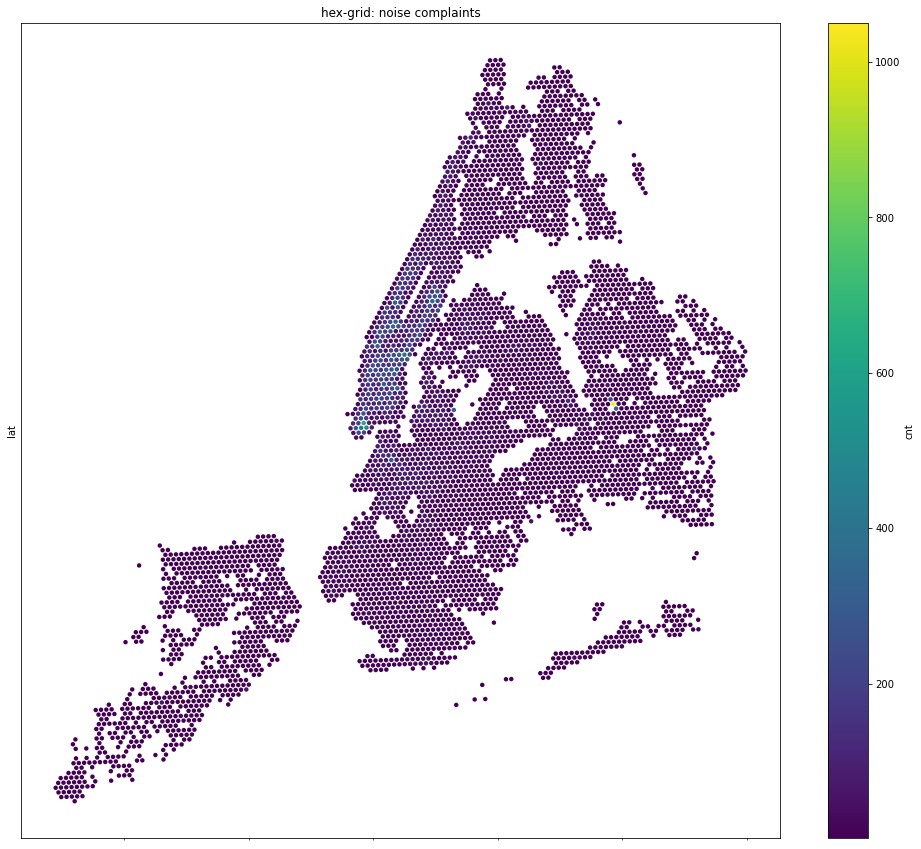

In [63]:
APERTURE_SIZE = 9
hex_col = 'hex'+str(APERTURE_SIZE)

# find hexs containing the points
df311[hex_col] = df311.apply(lambda x: h3.geo_to_h3(x.lat,x.lng,APERTURE_SIZE),1)

# aggregate the points
df311g = df311.groupby(hex_col).size().to_frame('cnt').reset_index()

#find center of hex for visualization
df311g['lat'] = df311g[hex_col].apply(lambda x: h3.h3_to_geo(x)[0])
df311g['lng'] = df311g[hex_col].apply(lambda x: h3.h3_to_geo(x)[1])

# pltot the hexs
plot_scatter(df311g, metric_col='cnt', marker='o',figsize=(17,15))
plt.title('hex-grid: noise complaints');

In [64]:
l = list(df311g[hex_col])
m = visualize_hexagons(l)
display(m)

<AxesSubplot:xlabel='lng', ylabel='lat'>

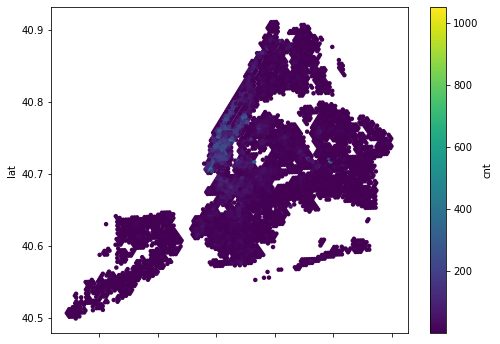

In [15]:
df = df311g
df.plot.scatter(x='lng', y='lat', c='cnt', edgecolors='none', colormap='viridis', marker='o', alpha=1, figsize=(8,6))

sum sanity check: 1.0


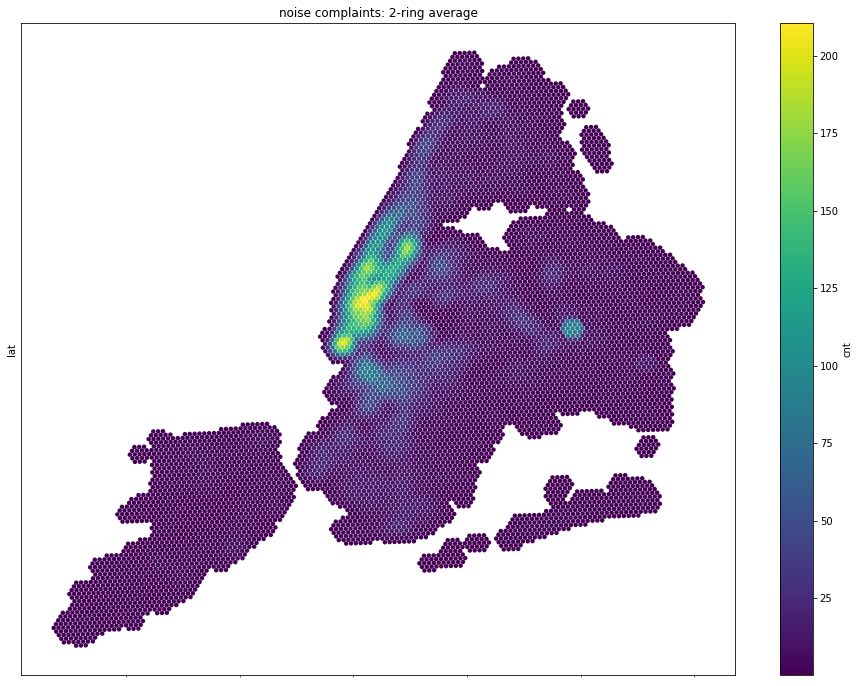

In [16]:
#kring_smoothing
k = 2
df311s= kring_smoothing(df311g, hex_col, metric_col='cnt', k=k)
print('sum sanity check:', df311s['cnt'].sum() / df311g['cnt'].sum())
plot_scatter(df311s, metric_col='cnt', marker='o')
plt.title('noise complaints: 2-ring average');

In [17]:
APERTURE_SIZE = 5
hex_col = 'hex'

# find hexs containing the points
df311[hex_col] = df311.apply(lambda x: h3.geo_to_h3(x.lat,x.lng,APERTURE_SIZE),1)

# aggregate the points
df311g = df311.groupby(hex_col).size().to_frame('cnt').reset_index()

l = list(df311g.hex)
m = visualize_hexagons(l, color='blue')
display(m)

<AxesSubplot:>

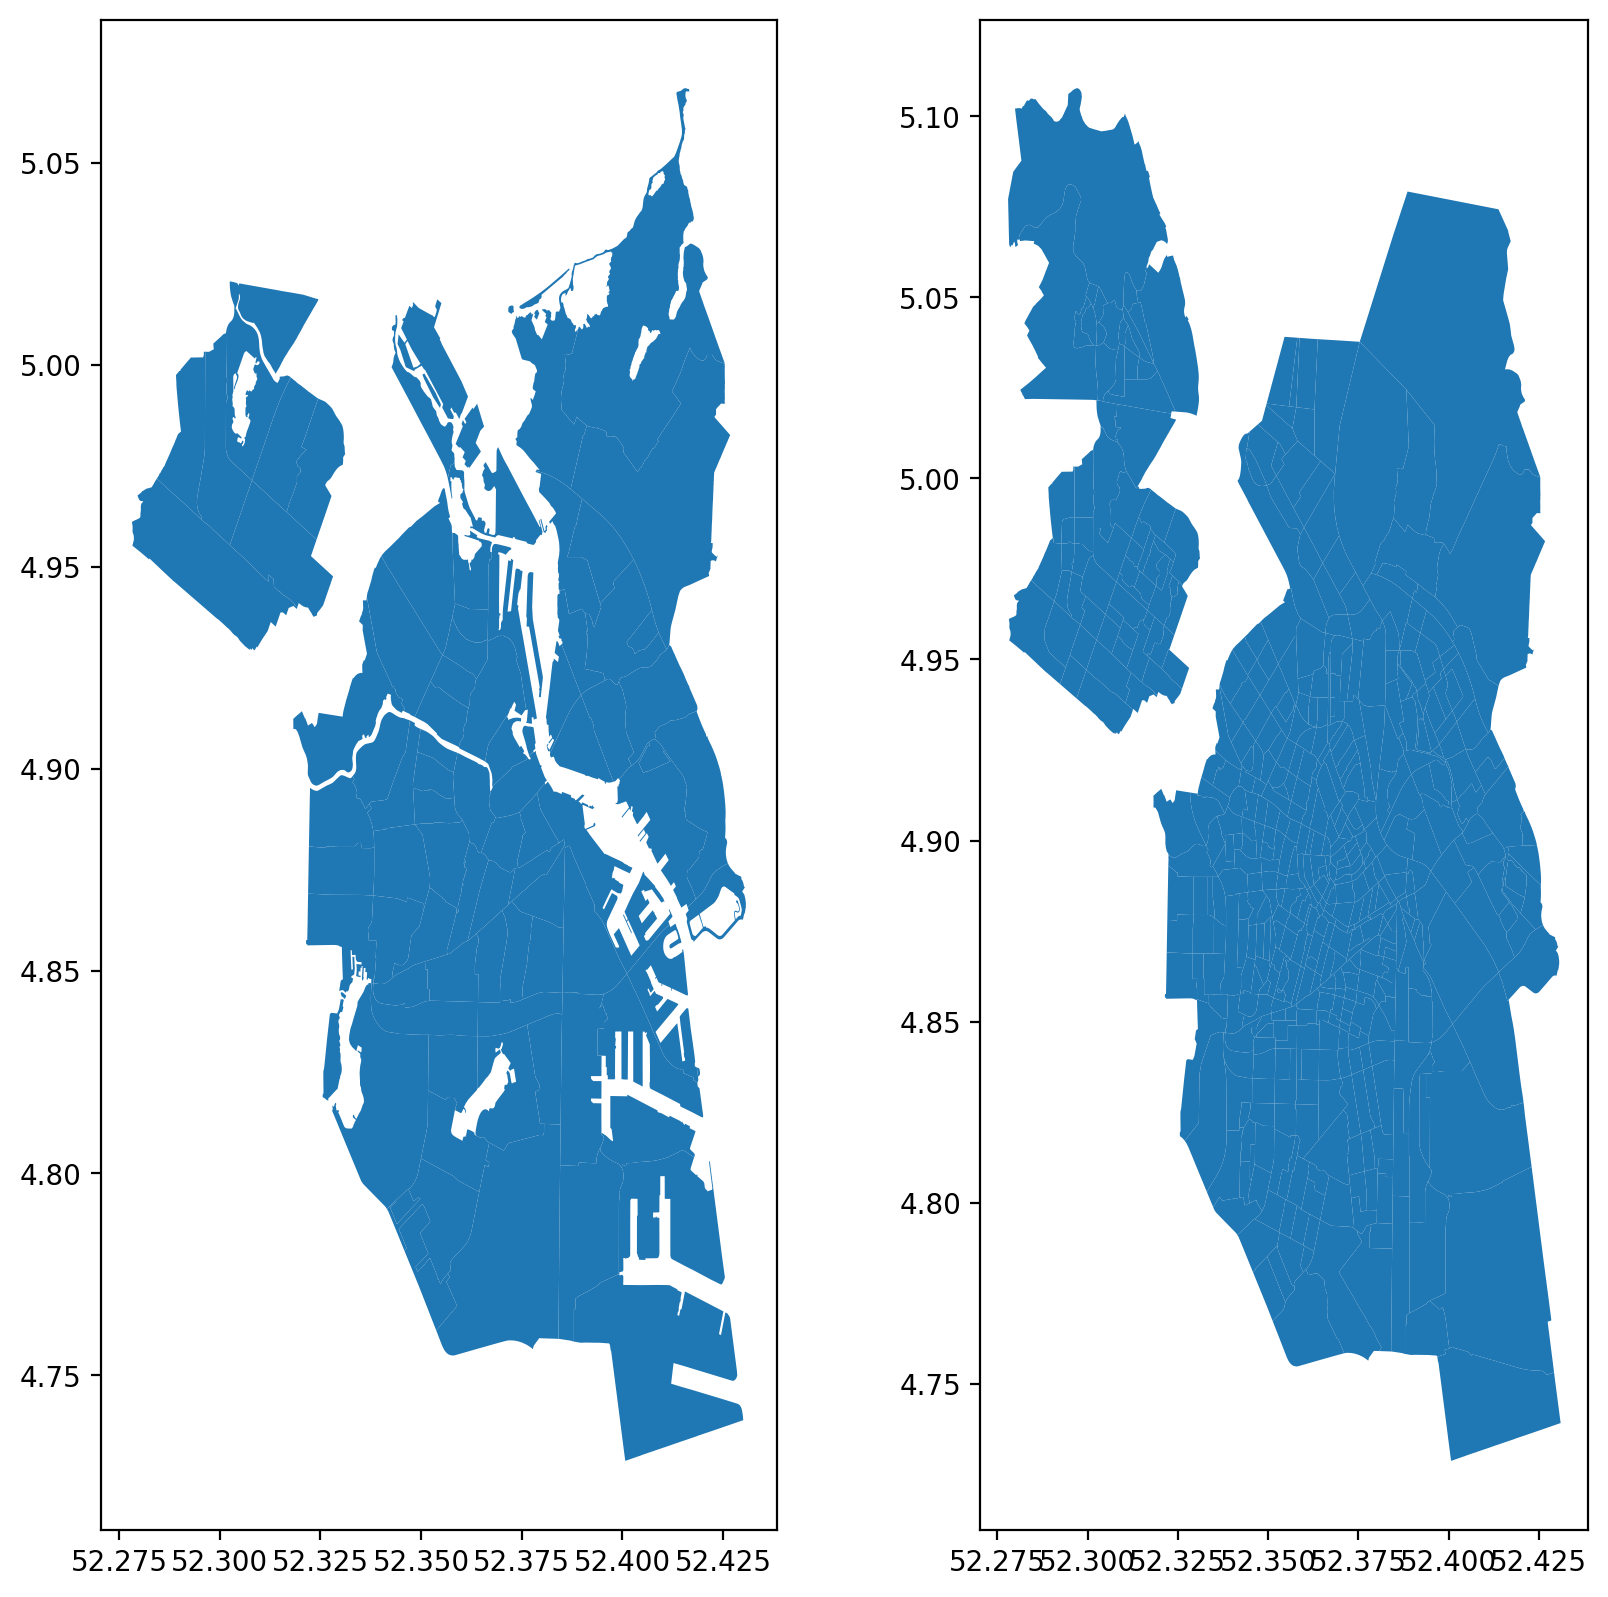

In [46]:
import geopandas as gpd
fig, ax = plt.subplots(dpi=200 ,nrows=1, ncols=2, figsize=(10,10))

df = gpd.read_file('https://maps.amsterdam.nl/open_geodata/geojson_latlng.php?KAARTLAAG=PC4_BUURTEN_EXWATER&THEMA=postcode')
df.plot(ax = ax[0])

df1 = gpd.read_file('https://maps.amsterdam.nl/open_geodata/geojson_latlng.php?KAARTLAAG=GEBIED_BUURTEN&THEMA=gebiedsindeling')
df1.plot(ax = ax[1])

In [4]:
params = MaaSSim.utils.get_config('glance.json')
params.city = "Amsterdam, Netherlands"
params.paths.G = "../../data/graphs/Amsterdam.graphml"
params.paths.skim = "../../data/graphs/Amsterdam.csv"

In [5]:
sim= MaaSSim.simulators.simulate(params=params)

22-04-22 09:36:21-WARNING-Setting up 4h simulation at 2022-04-22 07:55:53 for 2 vehicles and 5 passengers in Amsterdam, Netherlands
22-04-22 09:36:23-INFO--------------------	Starting simulation	-------------------
22-04-22 09:36:23-INFO-pax    0  got to dest at                           2022-04-22 08:17:22
22-04-22 09:36:23-INFO-pax    1  got to dest at                           2022-04-22 08:41:14
22-04-22 09:36:23-INFO-pax    2  got to dest at                           2022-04-22 10:38:46
22-04-22 09:36:23-INFO-pax    4  got to dest at                           2022-04-22 10:46:48
22-04-22 09:36:23-INFO-pax    3  got to dest at                           2022-04-22 10:48:37
22-04-22 09:36:23-INFO-veh    1  quitted shift                            2022-04-22 13:55:52
22-04-22 09:36:23-INFO-veh    2  quitted shift                            2022-04-22 13:55:52
22-04-22 09:36:23-INFO--------------------	Simulation over		-------------------
22-04-22 09:36:23-INFO-queue of requests 0
22-0

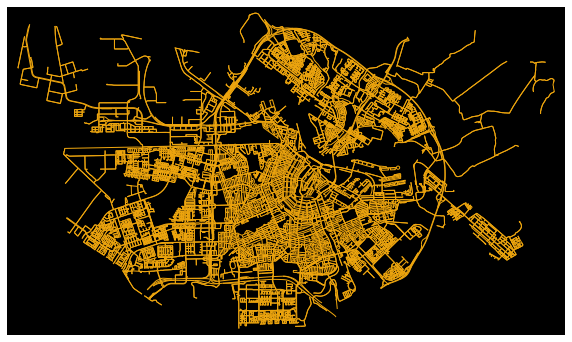

In [7]:
G = sim.inData.G
fig, ax = ox.plot_graph(G, figsize=(10, 10), show=False, close=False, node_size=0, bgcolor='black', 
                        edge_color=(0.933, 0.65, 0.059))

In [61]:
# Visualiziation of hexagons on Amsterdam map
lat = []
lng = []
for i in G.nodes:
    lat.append(G.nodes[i]['y'])
    lng.append(G.nodes[i]['x'])
    
df = pd.DataFrame()
df['lat'] = lat
df['lng'] = lng

level = 6
hex_col = 'hex'+str(level)
df[hex_col] = df.apply(lambda x: h3.geo_to_h3(x.lat,x.lng,level),axis=1)
df = df.groupby(hex_col).size().to_frame('cnt').reset_index()

l = list(df[hex_col])
m = visualize_hexagons(l)
display(m)